In [1]:
import sys
sys.path.insert(0, "../..")

In [67]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import pickle

from extrapolation import *
from nn_utils import *

In [3]:
torch.cuda.is_available()

True

## Training

In [4]:
trainer = Trainer(
    device="cuda",
    loss_fn=nn.NLLLoss(reduction="mean"),
    val_loss_fn=nn.NLLLoss(reduction="sum"),
)

In [5]:
dl = load_dataset(
    dataset="mnist", 
    root="../../../MNIST", 
    download=False, 
    validation_split=0.2,
    batch_size=64, 
    num_workers=2,
)

In [6]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(4*4*64, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(-1),
    )

In [7]:
model = make_model()
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
  (14): LogSoftmax(dim=-1)
)

In [8]:
optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.5, weight_decay=1e-5)

In [9]:
print(trainer.validation(model, dl["train"], log="train"))
print(trainer.validation(model, dl["valid"], log="valid"))

(0.09697916666666667, 2.3047567208607993)
(0.09891666666666667, 2.3050522600809735)


In [10]:
epochs = 150

parameter_log = [nn.utils.parameters_to_vector(model.parameters()).cpu().detach()]
for epoch in range(epochs):
    trainer.train_epoch(model, optimizer, dl["train"])
    train_acc, train_loss = trainer.validation(model, dl["train"], log="train")
    val_acc, val_loss = trainer.validation(model, dl["valid"], log="valid")
    print("Epoch", epoch+1, "|", 
          f"Training loss: {train_loss:.4f}, validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")
    parameter_log.append(nn.utils.parameters_to_vector(model.parameters()).cpu().detach())

100%|██████████| 750/750 [00:12<00:00, 58.11it/s, loss=2.2962]
Epoch 1 | Training loss: 2.2837, validation accuracy: 0.1073, validation loss: 2.2837
100%|██████████| 750/750 [00:13<00:00, 57.65it/s, loss=2.1280]
Epoch 2 | Training loss: 1.2372, validation accuracy: 0.7418, validation loss: 1.2231
100%|██████████| 750/750 [00:12<00:00, 58.04it/s, loss=0.5594]
Epoch 3 | Training loss: 0.3735, validation accuracy: 0.8951, validation loss: 0.3490
100%|██████████| 750/750 [00:12<00:00, 58.58it/s, loss=0.3323]
Epoch 4 | Training loss: 0.2865, validation accuracy: 0.9200, validation loss: 0.2690
100%|██████████| 750/750 [00:12<00:00, 58.44it/s, loss=0.2476]
Epoch 5 | Training loss: 0.2104, validation accuracy: 0.9389, validation loss: 0.2031
100%|██████████| 750/750 [00:12<00:00, 58.39it/s, loss=0.1925]
Epoch 6 | Training loss: 0.1698, validation accuracy: 0.9497, validation loss: 0.1680
100%|██████████| 750/750 [00:12<00:00, 58.85it/s, loss=0.1571]
Epoch 7 | Training loss: 0.1486, validation

In [11]:
torch.save(parameter_log, "SGD_plots_param_log.pt")

In [12]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

## Acceleration

In [13]:
model_acc = make_model()

In [14]:
k = 10

### RNA

In [15]:
lambda_ = 1e-10

q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        U = difference_matrix(xs)
        X = torch.vstack(xs[1:])
        x_acc = regularized_RRE(X, U, lambda_)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="RNA_train")
        trainer.validation(model_acc, dl["valid"], log="RNA_valid")

In [16]:
lambda_ = 1e-10

acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        U = difference_matrix(xs)
        X = torch.vstack(xs[1:])
        x_acc = regularized_RRE(X, U, lambda_)
        acc_log.append(x_acc)

In [17]:
lambda_ = 1e-10

q = deque(maxlen=k)
for x in acc_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        U = difference_matrix(xs)
        X = torch.vstack(xs[1:])
        x_acc = regularized_RRE(X, U, lambda_)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="RNA2_train")
        trainer.validation(model_acc, dl["valid"], log="RNA2_valid")

In [18]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

### RRE

In [19]:
acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        U = difference_matrix(xs)
        X = torch.vstack(xs[1:])
        x_acc = RRE(X, U)
        acc_log.append(x_acc)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="RRE_train")
        trainer.validation(model_acc, dl["valid"], log="RRE_valid")

In [20]:
q = deque(maxlen=k)
for x in acc_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        U = difference_matrix(xs)
        X = torch.vstack(xs[1:])
        x_acc = RRE(X, U)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="RRE2_train")
        trainer.validation(model_acc, dl["valid"], log="RRE2_valid")

In [21]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

### Vector epsilon

In [22]:
acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs[1:])
        x_acc = vector_epsilon_v1(X, k//2-1)
        acc_log.append(x_acc)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="vec_eps_train")
        trainer.validation(model_acc, dl["valid"], log="vec_eps_valid")

### Levin t

In [42]:
for key in list(trainer.validation_logs):
    if key.startswith("Levin"):
        trainer.validation_logs.pop(key)

In [43]:
trainer.validation_logs.keys()

dict_keys(['train_accuracy', 'train_loss', 'valid_accuracy', 'valid_loss', 'RNA_train_accuracy', 'RNA_train_loss', 'RNA_valid_accuracy', 'RNA_valid_loss', 'RNA2_train_accuracy', 'RNA2_train_loss', 'RNA2_valid_accuracy', 'RNA2_valid_loss', 'RRE_train_accuracy', 'RRE_train_loss', 'RRE_valid_accuracy', 'RRE_valid_loss', 'RRE2_train_accuracy', 'RRE2_train_loss', 'RRE2_valid_accuracy', 'RRE2_valid_loss', 'vec_eps_train_accuracy', 'vec_eps_train_loss', 'vec_eps_valid_accuracy', 'vec_eps_valid_loss'])

In [44]:
acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-2, type="t")
        acc_log.append(x_acc)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_t_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_t_valid")

In [46]:
q = deque(maxlen=k)
for x in acc_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-2, type="t")
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_t2_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_t2_valid")

In [48]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

### Levin u

In [49]:
acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-2, type="u")
        acc_log.append(x_acc)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_u_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_u_valid")

In [50]:
q = deque(maxlen=k)
for x in acc_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-2, type="u")
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_u2_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_u2_valid")

In [51]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

### Levin v

In [52]:
acc_log = []
q = deque(maxlen=k)
for x in parameter_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-3, type="v")
        acc_log.append(x_acc)
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_v_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_v_valid")

In [54]:
q = deque(maxlen=k)
for x in acc_log:
    q.append(x)
    if len(q) >= k:
        xs = list(q)
        X = torch.vstack(xs)
        x_acc = h_algorithm(X, k-3, type="v")
        nn.utils.vector_to_parameters(x_acc, model_acc.parameters())
        model_acc.cuda()
        trainer.validation(model_acc, dl["train"], log="Levin_v2_train")
        trainer.validation(model_acc, dl["valid"], log="Levin_v2_valid")

In [55]:
with open("validation_logs.p", "wb") as f:
    pickle.dump(dict(trainer.validation_logs), f)

## Analysis

In [61]:
l = len(trainer.validation_logs["train_accuracy"])
d = {}
for k, v in trainer.validation_logs.items():
    d[k] = [np.nan] * (l - len(v)) + v

In [63]:
df = pd.DataFrame(d)
df.head(20)

,train_accuracy,train_loss,valid_accuracy,valid_loss,RNA_train_accuracy,RNA_train_loss,RNA_valid_accuracy,RNA_valid_loss,RNA2_train_accuracy,RNA2_train_loss,...,Levin_u2_valid_accuracy,Levin_u2_valid_loss,Levin_v_train_accuracy,Levin_v_train_loss,Levin_v_valid_accuracy,Levin_v_valid_loss,Levin_v2_train_accuracy,Levin_v2_train_loss,Levin_v2_valid_accuracy,Levin_v2_valid_loss
0,0.096979,2.304757,0.098917,2.305052,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.105542,2.283657,0.107333,2.283718,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.727042,1.237246,0.741750,1.223076,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.890708,0.373460,0.895083,0.348959,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.914500,0.286457,0.920000,0.268982,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.935146,0.210432,0.938917,0.203100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.947083,0.169755,0.949750,0.168043,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.955646,0.148645,0.956583,0.147867,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.965458,0.116556,0.965000,0.121413,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.967542,0.107315,0.966583,0.113569,0.833167,1.587100,0.838500,1.579879,NaN,NaN,...,NaN,NaN,0.951000,0.161363,0.953000,0.159438,NaN,NaN,NaN,NaN


In [65]:
df.to_csv("acceleration_results.csv")

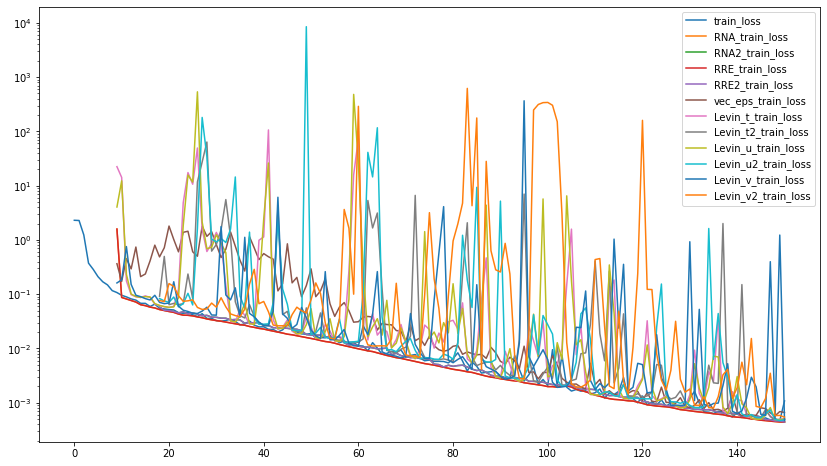

In [70]:
plt.figure(figsize=(14, 8))
for col in df.columns:
    if col.endswith("train_loss"):
        df[col].plot()
plt.yscale("log")
plt.legend()

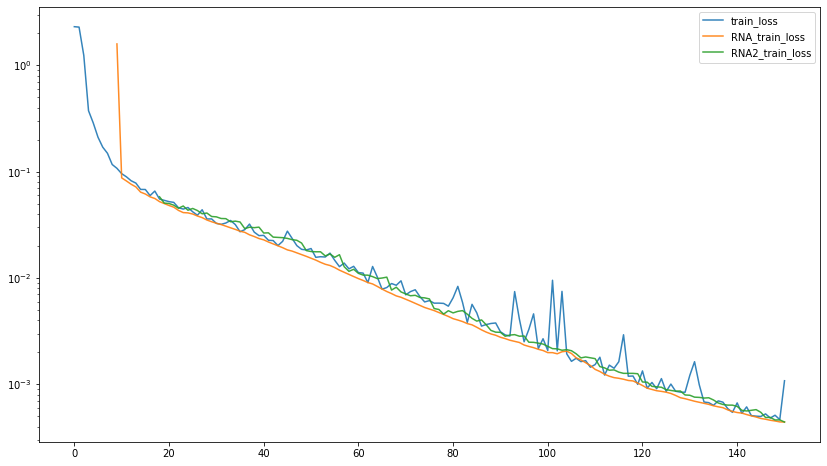

In [76]:
plt.figure(figsize=(14, 8))
for col in ["train_loss", "RNA_train_loss", "RNA2_train_loss"]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

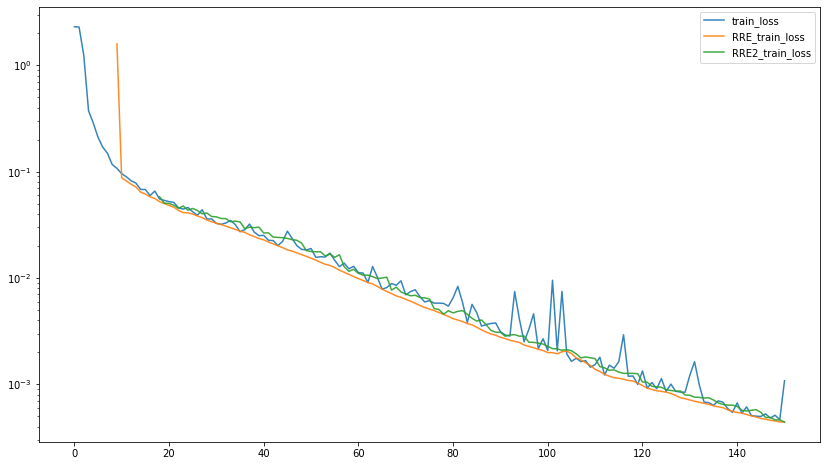

In [77]:
plt.figure(figsize=(14, 8))
for col in ["train_loss", "RRE_train_loss", "RRE2_train_loss"]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

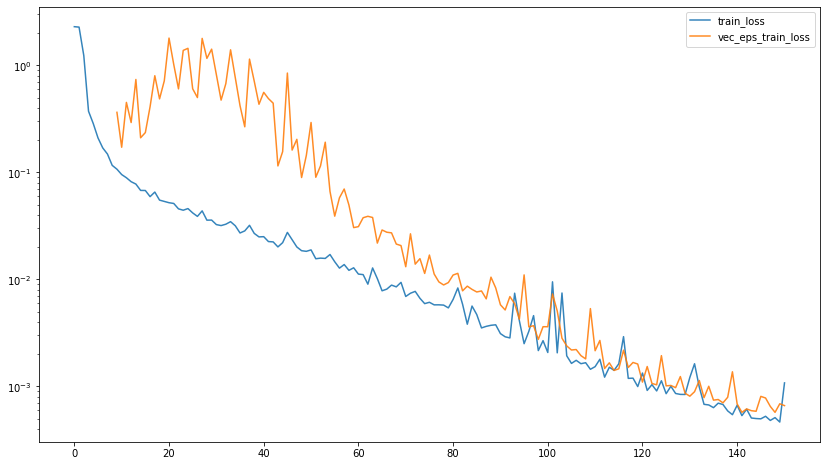

In [78]:
plt.figure(figsize=(14, 8))
for col in ["train_loss", "vec_eps_train_loss"]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

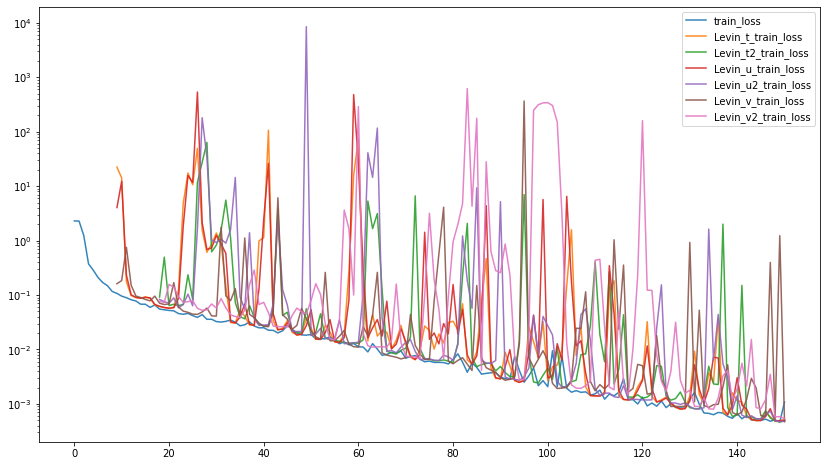

In [79]:
plt.figure(figsize=(14, 8))
for col in ["train_loss"] + [col for col in df.columns if col.endswith("train_loss") and col.startswith("Levin")]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

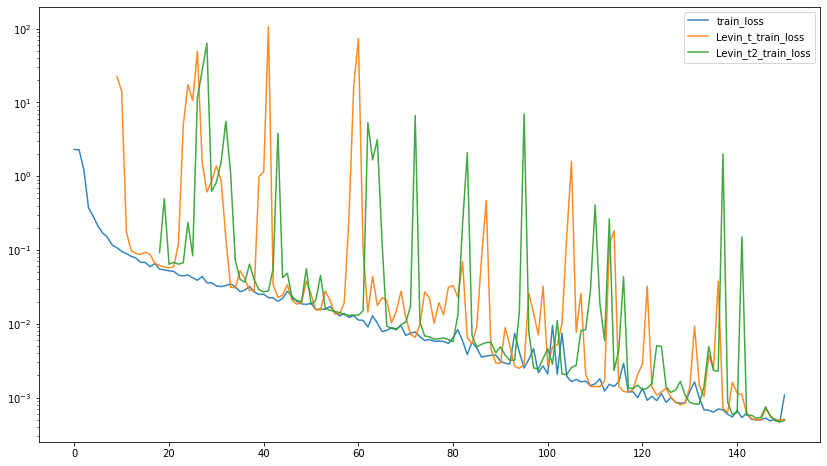

In [80]:
plt.figure(figsize=(14, 8))
for col in ["train_loss"] + [col for col in df.columns if col.endswith("train_loss") and col.startswith("Levin_t")]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

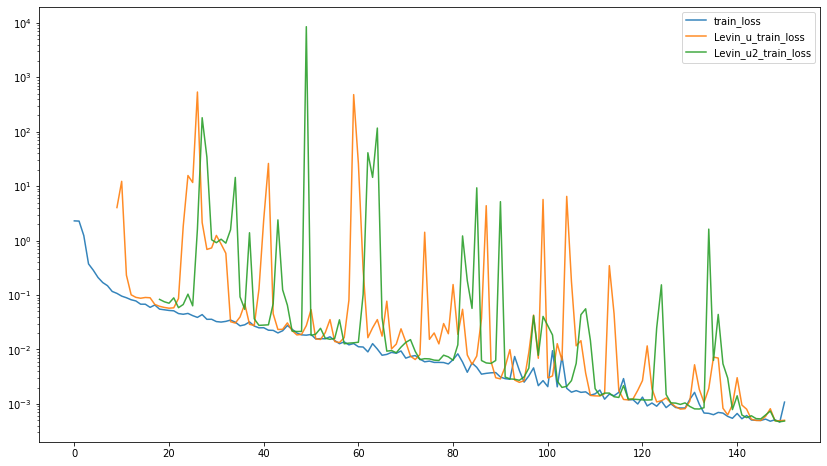

In [81]:
plt.figure(figsize=(14, 8))
for col in ["train_loss"] + [col for col in df.columns if col.endswith("train_loss") and col.startswith("Levin_u")]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()

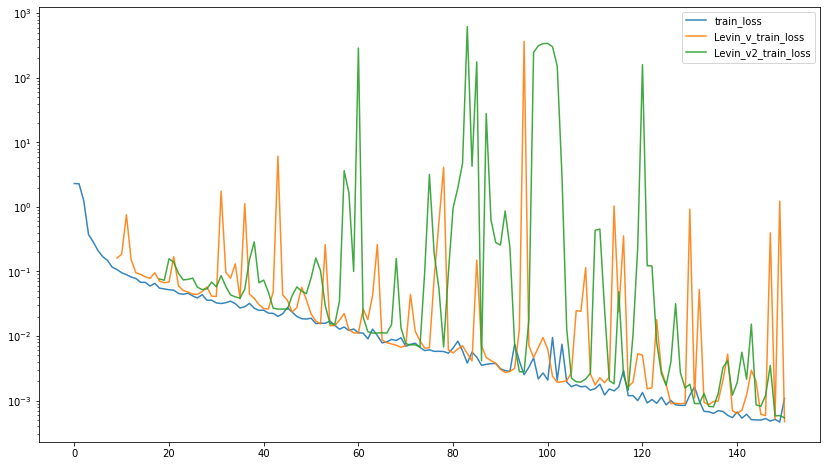

In [82]:
plt.figure(figsize=(14, 8))
for col in ["train_loss"] + [col for col in df.columns if col.endswith("train_loss") and col.startswith("Levin_v")]:
    df[col].plot(alpha=0.9)
plt.yscale("log")
plt.legend()